### Importing the Packages

In [45]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
#for word embedding

!pip install gensim 
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

## Importing the Training Data

In [7]:
df_train=pd.read_csv('game_train.csv')
print(df_train.shape)
df_train.head()

(10494, 5)


,review_id,title,year,user_review,user_suggestion
0,473,Sakura Clicker,2017.0,This has helped me through my stage 8 terminal...,1
1,22971,Crusaders of the Lost Idols,2017.0,Awesome idea. I support this game. I love that...,1
2,18225,RaceRoom Racing Experience,2014.0,"This game is just, such a♥♥♥♥♥♥take. The devel...",0
3,17132,Black Squad,2018.0,Early Access Reviewhere what i honesty think a...,1
4,8103,DCS World Steam Edition,2014.0,Very detailed sim and a joy to fly using a fli...,1


## Basic Statistics

1    5986
0    4508
Name: user_suggestion, dtype: int64


<AxesSubplot:ylabel='user_suggestion'>

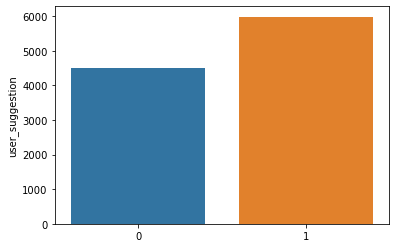

In [44]:
# CLASS DISTRIBUTION
#if dataset is balanced or not
x=df_train['user_suggestion'].value_counts()
print(x)
sns.barplot(x.index,x)

In [9]:
#Missing values
df_train.isna().sum()

review_id            0
title                0
year               108
user_review          0
user_suggestion      0
dtype: int64

In [10]:
print(type('user_review'))

<class 'str'>


In [11]:
#1. WORD-COUNT
df_train['word_count'] = df_train['user_review'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['user_suggestion']==1]['word_count'].mean()) #recommended
print(df_train[df_train['user_suggestion']==0]['word_count'].mean()) #not recommended
#Disaster tweets are more wordy than the non-disaster tweets

#2. CHARACTER-COUNT
df_train['char_count'] = df_train['user_review'].apply(lambda x: len(str(x)))
print(df_train[df_train['user_suggestion']==1]['char_count'].mean()) #recommended
print(df_train[df_train['user_suggestion']==0]['char_count'].mean()) #not recommended
#Disaster tweets are longer than the non-disaster tweets

#3. UNIQUE WORD-COUNT
df_train['unique_word_count'] = df_train['user_review'].apply(lambda x: len(set(str(x).split())))
print(df_train[df_train['user_suggestion']==1]['unique_word_count'].mean()) #recommended
print(df_train[df_train['user_suggestion']==0]['unique_word_count'].mean()) #not recommended

129.2978616772469
148.15372670807454
721.6996324757769
818.3362910381544
88.05897093217507
98.26153504880213


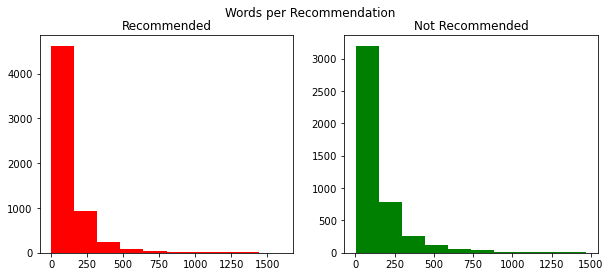

In [12]:
#Plotting word-count per Recommendation
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['user_suggestion']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Recommended')
train_words=df_train[df_train['user_suggestion']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Not Recommended')
fig.suptitle('Words per Recommendation')
plt.show()

## PRE-PROCESSING

In [13]:
# Common text preprocessing
user_review = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  adjacent spaces and tabs     .  "

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(user_review):
    user_review = user_review.lower() #lowercase text
    user_review = user_review.strip()  #get rid of leading/trailing whitespace 
    user_review = re.compile('<.*?>').sub('', user_review) #Remove HTML tags/markups
    user_review = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', user_review)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    user_review = re.sub('\s+', ' ', user_review)  #Remove extra space and tabs
    user_review = re.sub(r'\[[0-9]*\]',' ',user_review) #[0-9] matches any digit (0 to 10000...)
    user_review =re.sub(r'[^\w\s]', '', str(user_review).lower().strip())
    user_review = re.sub(r'\d',' ',user_review) #matches any digit from 0 to 100000..., \D matches non-digits
    user_review = re.sub(r'\s+',' ',user_review) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return user_review

user_review =preprocess(user_review)
print(user_review)  #text is a string

this is a message to be cleaned it may involve some things like adjacent spaces and tabs


In [46]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# Examples of Lexicon-based text processing
 
#1. Stopword Removal
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

user_review =stopword(user_review)
print(user_review)

message cleaned may involve things like adjacent spaces tabs


In [16]:
#2. Stemming
 
# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)
user_review =stemming(user_review)
print(user_review)

messag clean may involv thing like adjac space tab


In [17]:
#3. Lemmatization

# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

user_review = lemmatizer(user_review)
print(user_review)

messag clean may involv thing like adjac space tab


In [18]:
#Final Preprocessing

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df_train['clean_user_review'] = df_train['user_review'].apply(lambda x: finalpreprocess(x))
df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])
df_train.head()

,review_id,title,year,user_review,user_suggestion,clean_user_review
0,473,Sakura Clicker,2017.0,This has helped me through my stage 8 terminal...,1,help stage terminal brain cancer finally see v...
1,22971,Crusaders of the Lost Idols,2017.0,Awesome idea. I support this game. I love that...,1,awesome idea support game love keep make progr...
2,18225,RaceRoom Racing Experience,2014.0,"This game is just, such a♥♥♥♥♥♥take. The devel...",0,game atake developer want money thats everythi...
3,17132,Black Squad,2018.0,Early Access Reviewhere what i honesty think a...,1,early access reviewhere honesty think game gam...
4,8103,DCS World Steam Edition,2014.0,Very detailed sim and a joy to fly using a fli...,1,detailed sim joy fly use flightstick big drawb...


### Word2Vec model

In [36]:
#create Word2vec model

df_train['clean_user_review_tok']=[nltk.word_tokenize(i) for i in df_train['clean_user_review']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_user_review_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,

#if min_count=2 means if the word is present less than 2 times across all the documents then we should not consider it

#combination of word and its vector
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  

#converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

###  Train-Test Splitting of Train Dataset

In [20]:
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_user_review"],
                                                  df_train["user_suggestion"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      

#TF-IDF
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) 

#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

### Building ML models (Text-classification)

#### LR (tf-idf)

In [21]:
#Fitting the classification model using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train) 

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       912
           1       0.84      0.87      0.85      1187

    accuracy                           0.83      2099
   macro avg       0.83      0.83      0.83      2099
weighted avg       0.83      0.83      0.83      2099

Confusion Matrix: [[ 717  195]
 [ 156 1031]]
AUC: 0.9130270917394583


#### NB (tf-idf)

In [22]:
#Fitting the classification model using Naive Bayes(tf-idf)

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  


              precision    recall  f1-score   support

           0       0.92      0.50      0.65       912
           1       0.72      0.97      0.82      1187

    accuracy                           0.77      2099
   macro avg       0.82      0.73      0.74      2099
weighted avg       0.81      0.77      0.75      2099

Confusion Matrix: [[ 459  453]
 [  40 1147]]
AUC: 0.904468548160629


#### LR (w2v)

In [38]:
#Fitting the classification model using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

              precision    recall  f1-score   support

           0       0.76      0.70      0.73       912
           1       0.78      0.83      0.81      1187

    accuracy                           0.77      2099
   macro avg       0.77      0.77      0.77      2099
weighted avg       0.77      0.77      0.77      2099

Confusion Matrix: [[637 275]
 [199 988]]
AUC: 0.8571374466072511


### Test the Models with Test Dataset

In [39]:
df_test=pd.read_csv('game_test.csv') 
df_test['clean_user_review'] = df_test['user_review'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_user_review'] 

In [25]:
#Testing with the best model: Logistic Regression (tf-idf)
X_vector = tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector)      
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob'] = y_prob
df_test['user_suggestion'] = y_predict
print(df_test.head())

   review_id                        title    year  \
0          1  Spooky's Jump Scare Mansion  2016.0   
1          2  Spooky's Jump Scare Mansion  2016.0   
2          3  Spooky's Jump Scare Mansion  2016.0   
3          4  Spooky's Jump Scare Mansion  2015.0   
4          6  Spooky's Jump Scare Mansion  2015.0   

                                         user_review  \
0  I'm scared and hearing creepy voices.  So I'll...   
1  Best game, more better than Sam Pepper's YouTu...   
2  A littly iffy on the controls, but once you kn...   
3  Great game, fun and colorful and all that.A si...   
4  Early Access ReviewIt's pretty cute at first, ...   

                                   clean_user_review  predict_prob  \
0  scared hearing creepy voice pause moment write...      0.941876   
1  best game well sam pepper youtube account need...      0.945558   
2  littly iffy control know play easy master make...      0.977988   
3  great game fun colorful side note though get w...      0.9864

In [26]:
final=df_test[['review_id','user_suggestion']].reset_index(drop=True)
final.to_csv('k_submission.csv', index = False)

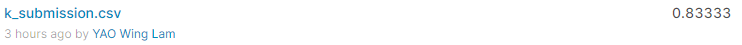

In [37]:
#Although it has a lower accuracy in the model, I would like to predict with it as reference.

#Testing with the Naive Bayes model
X_vector= tfidf_vectorizer.transform(X_test) #converting X_test to vector 
y_predict = nb_tfidf.predict(X_vector)     
y_prob = nb_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob'] = y_prob
df_test['user_suggestion'] = y_predict
print(df_test.head())

   review_id                        title    year  \
0          1  Spooky's Jump Scare Mansion  2016.0   
1          2  Spooky's Jump Scare Mansion  2016.0   
2          3  Spooky's Jump Scare Mansion  2016.0   
3          4  Spooky's Jump Scare Mansion  2015.0   
4          6  Spooky's Jump Scare Mansion  2015.0   

                                         user_review  \
0  I'm scared and hearing creepy voices.  So I'll...   
1  Best game, more better than Sam Pepper's YouTu...   
2  A littly iffy on the controls, but once you kn...   
3  Great game, fun and colorful and all that.A si...   
4  Early Access ReviewIt's pretty cute at first, ...   

                                   clean_user_review  predict_prob  \
0  scared hearing creepy voice pause moment write...      0.919021   
1  best game well sam pepper youtube account need...      0.839542   
2  littly iffy control know play easy master make...      0.861282   
3  great game fun colorful side note though get w...      0.7544

In [31]:
final=df_test[['review_id','user_suggestion']].reset_index(drop=True)
final.to_csv('k1_submission.csv', index = False) 

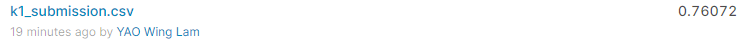

In [40]:
#Although it has a lower f1-score in the model, I would like to predict with it as reference.

#Testing with the Logistic Regression (W2v) model
X_vector= modelw.transform(X_test)      # Fit and transform
y_predict = lr_w2v.predict(X_vector)   
y_prob = lr_w2v.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['user_suggestion']= y_predict
print(df_test.head())

   review_id                        title    year  \
0          1  Spooky's Jump Scare Mansion  2016.0   
1          2  Spooky's Jump Scare Mansion  2016.0   
2          3  Spooky's Jump Scare Mansion  2016.0   
3          4  Spooky's Jump Scare Mansion  2015.0   
4          6  Spooky's Jump Scare Mansion  2015.0   

                                         user_review  \
0  I'm scared and hearing creepy voices.  So I'll...   
1  Best game, more better than Sam Pepper's YouTu...   
2  A littly iffy on the controls, but once you kn...   
3  Great game, fun and colorful and all that.A si...   
4  Early Access ReviewIt's pretty cute at first, ...   

                                   clean_user_review  predict_prob  \
0  scared hearing creepy voice pause moment write...      0.503291   
1  best game well sam pepper youtube account need...      0.409616   
2  littly iffy control know play easy master make...      0.600359   
3  great game fun colorful side note though get w...      0.4375

In [41]:
final=df_test[['review_id','user_suggestion']].reset_index(drop=True)
final.to_csv('k2_submission.csv', index = False) 

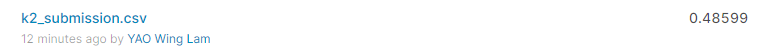

### Conclusion

The score of using Logistic Regression (tf-idf) to predict the outcome generated by Kaggle is 0.83333, which can be considered as a decent result. The score of using Naive Bayes(tf-idf) and Logistic Regression (W2v) model is 0.76072 and 0.48599 respectively. 

According to the results, using the algorithm: term frequency–inverse document frequency (tf-idf) is better in this case.

As other teammates have higher scores using other methods, such as deep learning, we decided to focus on tuning the models with the better result.

Besides, this code notebook is able to clearly show the steps of transforming the text data (in pre-processing) for the use of supervised learning.